In [117]:
import open3d as o3d
import numpy as np
import multiprocessing as mp
import copy as cp
import open3d.core as o3c
import matplotlib.pyplot as plt
import pyransac3d as pyrsc
from scipy.spatial.transform import Rotation
from iteration_utilities import deepflatten
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#load pcd file, filter, downsample
pcdn = o3d.io.read_point_cloud("final_cropped.pcd")
pcdn.estimate_normals()
cl, ind = pcdn.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=0.8)

pcd = pcdn.select_by_index(ind)
pcd = pcd.voxel_down_sample(voxel_size=0.1)
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(40)
o3d.visualization.draw_geometries([pcd])

In [3]:
# detect boundarys in pointcloud

test2 = cp.deepcopy(pcd)

tensor_pcd = o3d.t.geometry.PointCloud.from_legacy(test2)

boundarys, mask = tensor_pcd.compute_boundary_points(0.2, 100, 95)
# TODO: not good to get size of points.
print(f"Detect {boundarys.point.positions.shape[0]} bnoundary points from {tensor_pcd.point.positions.shape[0]} points.")

boundarys = boundarys.paint_uniform_color([1.0, 0.0, 0.0])
cl, ind = boundarys.to_legacy().remove_radius_outlier(2, 0.2)
boundarys = boundarys.select_by_index(ind)


o3d.visualization.draw_geometries([tensor_pcd.to_legacy().paint_uniform_color([0, 0, 0.0]), boundarys.to_legacy()])

Detect 15121 bnoundary points from 106083 points.


In [4]:
# detect patches in boundary points

test4 = cp.deepcopy(boundarys.to_legacy())


test4.estimate_normals()
test4.orient_normals_consistent_tangent_plane(30)


n_points = len(test4.points)
#o3d.visualization.draw([pcd_down])
# using all defaults
oboxes = test4.detect_planar_patches(
normal_variance_threshold_deg=60,
coplanarity_deg=80,
outlier_ratio=0.75,
min_plane_edge_length=1,
min_num_points=5,
search_param=o3d.geometry.KDTreeSearchParamKNN(knn=50))

print("Detected {} patches".format(len(oboxes)))

geometries = []
for obox in oboxes:

    mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
    mesh.paint_uniform_color(obox.color)
    mesh.compute_triangle_normals()
    mesh.compute_vertex_normals()
    normals = np.asarray(mesh.vertex_normals)

    
    geometries.append(mesh)
    #geometries.append(obox)

o3d.visualization.draw_geometries(geometries )
#o3d.visualization.draw_geometries([pcd])

Detected 48 patches


In [5]:
def add_vector_to_point(point, vector, length):
    

    # Calculate the new point coordinates
    new_point = point + length * vector

    # Return the new point as a NumPy array
    return new_point

In [6]:
def calc_mesh_area_sorted(meshes):
    areas = np.zeros((len(meshes),2))
    for i in range(len(meshes)):
        mesh_bb = meshes[i].get_oriented_bounding_box()
        area = mesh_bb.volume()/mesh_bb.extent[2]
        areas[i][0] = i
        areas[i][1] = area
    sorted_indices = np.argsort(areas[:, 1])[::-1]
    return areas[sorted_indices]
        

In [7]:
dimensions = calc_mesh_area_sorted(geometries)


In [8]:
middle = geometries[40].get_center()
normal = np.asarray(geometries[40].vertex_normals)[0]

cam_pos = add_vector_to_point(middle, normal, 5)
print(middle)
print(cam_pos)
cam_pos[2] = 0.5
middle[2] = 0.5
print(middle)
print(cam_pos)

[-33.21386672   2.33273776   0.28282666]
[-38.20450704   2.09602269   0.08924143]
[-33.21386672   2.33273776   0.5       ]
[-38.20450704   2.09602269   0.5       ]


In [9]:
scene = o3d.t.geometry.RaycastingScene()

for mesh in geometries:
    
    scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))



In [98]:
def is_perpendicular(angle, threshold):
    
    if (180 <= angle < 360):
        angle -= 180
        
    if ((90-threshold) <= angle <= (90+threshold)):
        return True
    else:
        return False


In [112]:
def count_hits_ray_cast(cast_distances, cast_normals, cam_normal, dist_thresh, angle_thresh):
    dist_lower = dist_thresh[0]
    dist_upper = dist_thresh[1]
    n_valid_hits = 0
    flattened_dist_array = cast_distances.flatten()
    n_pixels = len(flattened_dist_array)
    flattened_normal_array = cast_normals.reshape(n_pixels,3)

    

    
    for i in range(n_pixels):
        
        if (flattened_dist_array[i] >= dist_lower) & (flattened_dist_array[i] <= dist_upper):
            pass
        else:
            continue
        
        point_normal = flattened_normal_array[i]
        angle = angle_between_vectors(point_normal, cam_normal)
        
        if is_perpendicular(angle, angle_thresh):
            continue
        else:
            n_valid_hits += 1
        
            
    #n_valid_hits = np.sum((flattened_dist_array >= dist_lower) & (flattened_dist_array <= dist_upper) & angles)
    
    return n_valid_hits/n_pixels
    

In [132]:
def process_pixel(pixel_data):
    flattened_dist_array, flattened_normal_array, dist_lower, dist_upper, cam_normal, angle_thresh = pixel_data
    n_valid_hits = 0
    
    for i in range(len(flattened_dist_array)):
        if (flattened_dist_array[i] >= dist_lower) and (flattened_dist_array[i] <= dist_upper):
            point_normal = flattened_normal_array[i]
            angle = angle_between_vectors(point_normal, cam_normal)
            
            if is_perpendicular(angle, angle_thresh):
                continue
            else:
                n_valid_hits += 1
    
    return n_valid_hits

def count_hits_ray_cast2(cast_distances, cast_normals, cam_normal, dist_thresh, angle_thresh):
    dist_lower = dist_thresh[0]
    dist_upper = dist_thresh[1]
    flattened_dist_array = cast_distances.flatten()
    n_pixels = len(flattened_dist_array)
    flattened_normal_array = cast_normals.reshape(n_pixels, 3)
    
    pixel_data = [(flattened_dist_array, flattened_normal_array, dist_lower, dist_upper, cam_normal, angle_thresh)] * n_pixels

    num_processes = mp.cpu_count()  # Number of available CPU cores
    pool = mp.Pool(processes=num_processes)
    
    results = pool.map(process_pixel, pixel_data)
    pool.close()
    pool.join()
    
    n_valid_hits = sum(results)
    hit_ratio = n_valid_hits / n_pixels
    
    return hit_ratio


In [11]:
def compute_transform(vector1, vector2):
    # Normalize the vectors to unit length
    vector1 = vector1 / np.linalg.norm(vector1)
    vector2 = vector2 / np.linalg.norm(vector2)

    # Compute the rotation matrix
    rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()

    # Compute the translation vector
    translation_vector = vector2 - np.dot(rotation_matrix, vector1)

    return translation_vector, rotation_matrix

In [12]:
def rotation_matrix_to_axis_angle(matrix):
    r = Rotation.from_matrix(matrix)
    return r.as_euler('xyz', degrees=True)

In [13]:
def invert_normalized_vector(vector):
    inverted_vector = []
    for component in vector:
        inverted_component = -component
        inverted_vector.append(inverted_component)
    return inverted_vector

In [14]:
def visualize_3d_vectors(vector1, vector2):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # normalize vectors
    vector1 = vector1 / np.linalg.norm(vector1)
    vector2 = vector2 / np.linalg.norm(vector2)
    
    if check_vector_similar_direction(vector1, vector2):
        pass
    else:
        pass
        #vector2 = invert_normalized_vector(vector2)
        
    
    # Extract individual coordinates from the vectors
    x1, y1, z1 = vector1
    x2, y2, z2 = vector2
    
    # Plot the vectors as lines
    ax.plot([0, x1], [0, y1], [0, z1], color='r', label='Cam orientation')
    ax.plot([0, x2], [0, y2], [0, z2], color='b', label='Plane normal orientation')
    
    # Set the limits and labels of the plot
    max_x = max(np.max(x1), np.max(x2))
    max_y = max(np.max(y1), np.max(y2))
    max_z = max(np.max(z1), np.max(z2))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add a legend
    ax.legend()
    
    # Show the plot
    plt.show()

In [15]:
def check_vector_similar_direction(vec1, vec2):
    
    # Normalize the vectors
    normalized_vec1 = np.array(vec1) / np.linalg.norm(vec1)
    normalized_vec2 = np.array(vec2) / np.linalg.norm(vec2)
    
    # Calculate the dot product
    dot_product = np.dot(normalized_vec1, normalized_vec2)
    
    if (dot_product > 0):
        return True
    else:
        return False

In [16]:
def create_arrow_from_vector(vector, location):
    mesh_normal = vector
    mesh_center = location
    
    #print("Norm average:")
    #print(norm_average)
    
    arrow = o3d.geometry.TriangleMesh.create_cone(0.5,1)
    
    arrow.paint_uniform_color([1,0,0])
    arrow_bb = arrow.get_oriented_bounding_box()
    arrow.compute_triangle_normals()
    arrow.compute_vertex_normals()
    arrow_normal = np.asarray(arrow.vertex_normals)[0]

    translation, rotation = compute_transform(mesh_normal, arrow_normal)  
    
    arrow.rotate(rotation)
    
    arrow.translate(mesh_center, False)
    
    
    arrow_normal = np.asarray(arrow.vertex_normals)[0]
    arrow_center = arrow.get_center()
    same_dir = check_vector_similar_direction(arrow_normal,mesh_normal)
    R_x = np.asarray([[1, 0, 0],
                       [0, -1, 0],
                       [0, 0, -1]])
    
    arrow_cp = o3d.geometry.TriangleMesh.create_cone(0.5,1)
    arrow_cp.paint_uniform_color([1,0,0])
    arrow_cp.compute_triangle_normals()
    arrow_cp.compute_vertex_normals()
    if  (same_dir):
        arrow_cp.rotate(R_x, arrow_center)
        arrow_cp.rotate(rotation)
        arrow_cp.translate(mesh_center, False)
        return arrow_cp
    else:
        return arrow
    

In [128]:
def process_hole(hole):
    scene = o3d.t.geometry.RaycastingScene()
    dist_thresh, angle_thresh = (2,10), 20
    
    
    for test in geometries:
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(test))
    center = hole.get_center()
    normal = np.asarray(hole.vertex_normals)[0]
    cam_pos = add_vector_to_point(center, normal, 5)
    cam_normal = (center - cam_pos)
    
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
        fov_deg=90,
        center=center,
        eye=cam_pos,
        up=[0, 0, -1],
        width_px=1080,
        height_px=1080
    )
    ans = scene.cast_rays(rays)
    
    cast_normals = ans['primitive_normals'].numpy()
    cast_distances = ans['t_hit'].numpy()
    hits = count_hits_ray_cast(cast_distances, cast_normals, cam_normal, dist_thresh, angle_thresh)
    
    return hits

In [129]:
def rank_all_views2(hole_patches, dist_thresh, angle_thresh):
    
    
    num_processes = mp.cpu_count()  # Number of available CPU cores
    pool = mp.Pool(processes=num_processes)
    
    
    
    
    
    
    scene = o3d.t.geometry.RaycastingScene()
    hole_centers = []
    hole_normals = []
    cam_positions = []
    hit_area = []
    for hole in hole_patches:
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(hole))
    
    print("here")
    results = pool.map(process_hole, hole_patches)
    pool.close()
    pool.join()
    
    hit_area = results
    return hit_area

        
ranked_views2 = rank_all_views2(geometries, (2,10), 10 )

here


TypeError: cannot pickle 'open3d.cuda.pybind.geometry.TriangleMesh' object

Process ForkPoolWorker-120:
Process ForkPoolWorker-102:
Process ForkPoolWorker-111:
Process ForkPoolWorker-107:
Process ForkPoolWorker-114:
Process ForkPoolWorker-112:
Process ForkPoolWorker-98:
Process ForkPoolWorker-109:
Process ForkPoolWorker-116:
Process ForkPoolWorker-99:
Process ForkPoolWorker-119:
Process ForkPoolWorker-108:
Process ForkPoolWorker-104:
Process ForkPoolWorker-118:
Process ForkPoolWorker-113:
Process ForkPoolWorker-110:
Process ForkPoolWorker-103:
Process ForkPoolWorker-97:
Process ForkPoolWorker-101:
Process ForkPoolWorker-117:
Process ForkPoolWorker-100:
Process ForkPoolWorker-106:
Process ForkPoolWorker-115:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback

  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/queues.py", 

In [133]:
def rank_all_views(hole_patches, dist_thresh, angle_thresh):
    
    scene = o3d.t.geometry.RaycastingScene()
    hole_centers = []
    hole_normals = []
    cam_positions = []
    hit_area = []
    for hole in hole_patches:
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(hole))
    
    print("processing holes")
    for hole in hole_patches:
        
        center = hole.get_center()
        normal = np.asarray(hole.vertex_normals)[0]
        cam_pos = add_vector_to_point(center, normal, 5)
        cam_normal = (center-cam_pos)
        hole_centers.append(center)
        hole_normals.append(normal)
        cam_positions.append(cam_pos)

        
        rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
                fov_deg=90,
                center=center,
                eye=cam_pos,
                up=[0, 0, -1],
                width_px=1080,
                height_px=1080)
        ans = scene.cast_rays(rays)
        
        cast_normals = ans['primitive_normals'].numpy()
        cast_distances = ans['t_hit'].numpy()
        hits = count_hits_ray_cast(cast_distances, cast_normals, cam_normal, dist_thresh, angle_thresh)
        hit_area.append(hits)
        print("appended area")
    return hit_area

        
ranked_views = rank_all_views(geometries, (2,10), 10 )

processing holes


Process ForkPoolWorker-186:
Process ForkPoolWorker-194:
Process ForkPoolWorker-185:
Process ForkPoolWorker-180:
Process ForkPoolWorker-187:
Process ForkPoolWorker-173:
Process ForkPoolWorker-183:
Process ForkPoolWorker-182:
Process ForkPoolWorker-174:
Process ForkPoolWorker-190:
Process ForkPoolWorker-172:
Process ForkPoolWorker-179:
Process ForkPoolWorker-191:
Process ForkPoolWorker-178:
Process ForkPoolWorker-189:
Process ForkPoolWorker-171:
Process ForkPoolWorker-192:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-184:
Process ForkPoolWorker-188:
Process ForkPoolWorker-181:
Process ForkPoolWorker-175:
Traceback (most recent call last):
Process ForkPoolWorker-193:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap

  File "/tmp/ipykernel_5517/2545671129.py", line 14, in angle_between_vectors
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/tmp/ipykernel_5517/901046983.py", line 6, in process_pixel
    if (flattened_dist_array[i] >= dist_lower) and (flattened_dist_array[i] <= dist_upper):
  File "/tmp/ipykernel_5517/901046983.py", line 8, in process_pixel
    angle = angle_between_vectors(point_normal, cam_normal)
  File "/usr/lib/python3.8/multiprocessing/pool.py", l

  File "/home/max/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc
    return bound(*args, **kwds)
  File "/home/max/.local/lib/python3.8/site-packages/numpy/core/_methods.py", line 136, in _clip
    if _clip_dep_is_scalar_nan(min):
  File "/home/max/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc
    return bound(*args, **kwds)
  File "/home/max/.local/lib/python3.8/site-packages/numpy/core/_methods.py", line 136, in _clip
    if _clip_dep_is_scalar_nan(min):
  File "/home/max/.local/lib/python3.8/site-packages/numpy/core/_methods.py", line 108, in _clip_dep_invoke_with_casting
    def _clip_dep_invoke_with_casting(ufunc, *args, out=None, casting=None, **kwargs):
  File "/home/max/.local/lib/python3.8/site-packages/numpy/core/_methods.py", line 136, in _clip
    if _clip_dep_is_scalar_nan(min):
  File "/home/max/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc
    return bound(

KeyboardInterrupt: 

  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/tmp/ipykernel_5517/901046983.py", line 8, in process_pixel
    angle = angle_between_vectors(point_normal, cam_normal)
  File "/tmp/ipykernel_5517/2545671129.py", line 12, in angle_between_vectors
    v1_u = v1 / np.linalg.norm(v1)
  File "<__array_function__ internals>", line 200, in norm
  File "/home/max/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py", line 2511, in norm
    sqnorm = x.dot(x)
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _boots

In [116]:
print(ranked_views)

[0.4309953703703704, 0.03457990397805213, 0.04048611111111111, 0.041205418381344304, 0.04217421124828532, 0.01564900548696845, 0.27661265432098764, 0.145815329218107, 0.09093535665294925, 0.0010150891632373113, 0.03433813443072702, 0.047479423868312755, 0.14374399862825787, 0.33323216735253774, 0.2351431755829904, 0.04339420438957476, 0.2626071673525377, 0.31491598079561045, 0.3019264403292181, 0.08522376543209877, 0.5770010288065843, 0.2514557613168724, 7.20164609053498e-05, 0.07051526063100137, 0.22522462277091906, 0.1197119341563786, 0.109275548696845, 0.15520576131687241, 0.03464163237311386, 0.25380658436213993, 0.046883573388203016, 0.029391289437585733, 0.32987139917695474, 0.07957990397805213, 0.007301954732510288, 0.5451071673525377, 0.04384259259259259, 0.7009079218106996, 0.2991898148148148, 0.5913365912208505, 0.015727880658436215, 0.5130581275720164, 0.0, 0.20550668724279836, 0.20373113854595337, 0.3999365569272977, 0.1907193072702332, 0.37295181755829904]


Normal of plane:  [-0.9981269  -0.04736071 -0.03872389]
Camera direction:  [4.99064031 0.23671507 0.        ]
[-5.26288119e-02  2.21927027e+00  1.79998978e+02]


/tmp/ipykernel_5517/927153186.py:7: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()


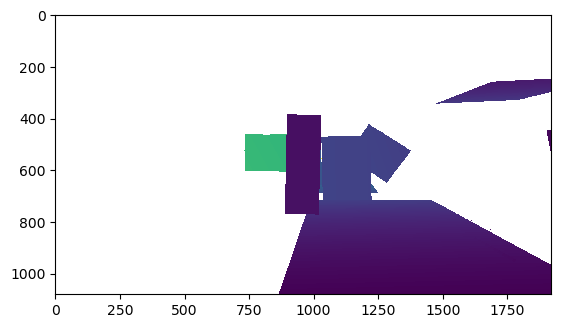

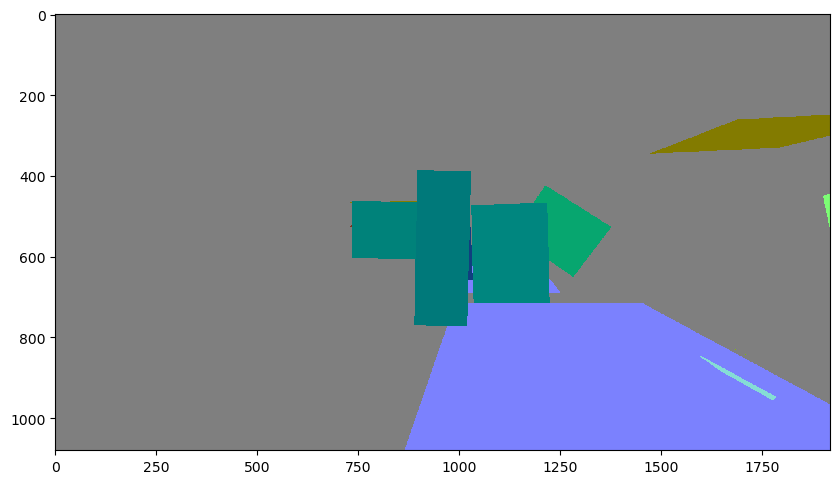

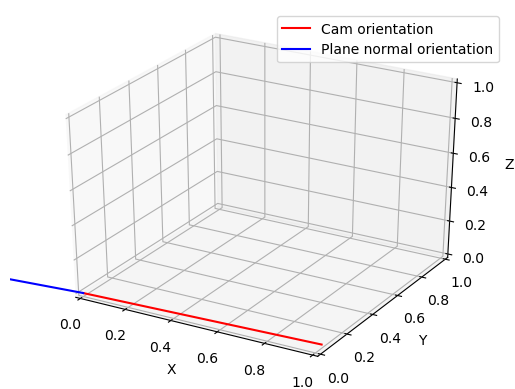

In [20]:
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=middle,
    eye=cam_pos,
    up=[0, 0, -1],
    width_px=1920,
    height_px=1080,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)
plt.imshow(ans['t_hit'].numpy())

normals = ans['primitive_normals'].numpy()

normals_interp = np.interp(normals, (normals.min(), normals.max()), (0, 1))
plt.figure(figsize=(10,6))
plt.imshow(normals_interp)
plt.savefig('test.png')
hits = ans['t_hit'].numpy()

print("Normal of plane: " ,normals[500,999])
print("Camera direction: ", (middle-cam_pos))

_, rot_mat = compute_transform(normals[500,999],(middle-cam_pos))
print(rotation_matrix_to_axis_angle(rot_mat))
visualize_3d_vectors((middle-cam_pos), normals[500,999] )


In [54]:
def angle_between_vectors(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    # Normalize the vectors to unit length
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
    return np.degrees(angle)


[-63.43494882   0.          90.        ]
90.0


/tmp/ipykernel_5517/927153186.py:7: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()


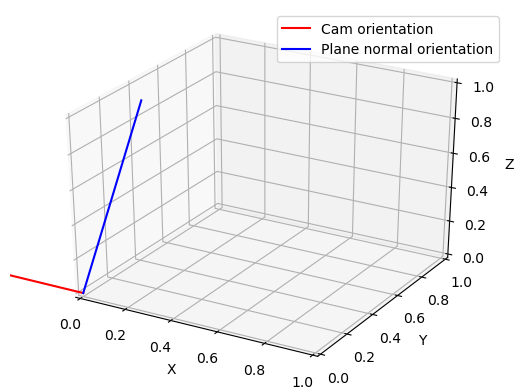

In [55]:
vec1 = np.asarray([-1,0,0])
vec2 = np.asarray([0,1,2])

_, rot_mat = compute_transform(vec1 ,vec2)
print(rotation_matrix_to_axis_angle(rot_mat))
print(angle_between_vectors(vec1, vec2))
visualize_3d_vectors(vec1 ,vec2)


In [19]:
cone = create_arrow_from_vector(cam_pos-middle, cam_pos)
print(cone.get_center())
o3d.visualization.draw_geometries(geometries + [cone] )

[-38.20450704   2.09602269   0.5       ]


/tmp/ipykernel_5517/927153186.py:7: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()
